In [1]:
!pip install matplotlib
!pip install gymnasium==0.28.1
!pip install stable_baselines3==2.1.0
!pip install tqdm

!pip install gym
!pip install stable_baselines
!pip install tensorflow
!pip install shimmy>=0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [2]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.evaluation import evaluate_policy

np.set_printoptions(precision=3)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [3]:
class StaticAgent:
    def __init__(self, action):
      self.action = action

    def act(self, state):
        return self.action

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class RandomAgent:
    def __init__(self, risk_level = 0.5):
        self.risk_level = risk_level

    def act(self, state):
      action = random.randint(0, 4)
      if np.random.rand() < self.risk_level:
        action += 5
      return action

In [5]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()


    def reset(self):
        self.change_tyre(self.default_tyre)


    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)


    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00


    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

In [6]:
class Track:
    def __init__(self, opponents, mode = "train"):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.opponents = opponents
        self.mode = mode
        self.cars = [Car() for _ in range(len(self.opponents) + 1)]
        # Target agent's index
        self.target = len(self.opponents)
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()

    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.complexity = [0.00, 0.50, 1.00][np.random.randint(0, 3)]
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstops = [False for i in range(len(self.cars))]
        self.laps_cleared = 0
        self.commited_tyres = np.full_like(self.cars, -1)
        self.time_taken = np.zeros_like(self.cars)
        self.actions = [1 for i in range(len(self.cars))]

        for car in self.cars:
          car.reset()
        return self._get_state()

    def _get_state(self):
      return self._get_states()[self.target]

    def _get_states(self):
      qualified = list(filter(lambda x: x is not None, self.time_taken))

      return [
          [
              self.cars[i].tyre,
              self.cars[i].condition,
              self.wetness[self.cur_weather],
              self.radius,
              self.laps_cleared,
              self.complexity,
              None if self.time_taken[i] is None else len(list(filter(lambda x : x < self.time_taken[i], qualified))),
              None if self.time_taken[i] is None else len(list(filter(lambda x : x > self.time_taken[i], qualified))),
          ] for i in range(len(self.cars))]

    def __calculate_reward(self):
      # Disqualified
      if self.time_taken[self.target] is None:
        return 0

      if self.laps_cleared < self.total_laps:
        lap_reward = 1 if self.mode == "train" else 0
        return lap_reward * 0.125
      else:
        qualified = list(filter(lambda x: x is not None, self.time_taken))
        front = len(list(filter(lambda x : x < self.time_taken[self.target], qualified)))
        reward = [1000, 500, 400, 80][min([3, front])]

        if self.mode == "train":
          i = 3
          while front > i:
            reward *= 0.95
            i += 1

        return reward

    def transition(self, action):
        """
        Args:
            action (int):
                0. [Conservative] Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. [Conservative] Make a pitstop and fit new ‘Soft’ tyres
                2. [Conservative] Make a pitstop and fit new ‘Intermediate’ tyres
                3. [Conservative] Make a pitstop and fit new ‘Fullwet’ tyres
                4. [Conservative] Continue the next lap without changing tyres
                5. [Reckless] Make a pitstop and fit new ‘Ultrasoft’ tyres
                6. [Reckless] Make a pitstop and fit new ‘Soft’ tyres
                7. [Reckless] Make a pitstop and fit new ‘Intermediate’ tyres
                8. [Reckless] Make a pitstop and fit new ‘Fullwet’ tyres
                9. [Reckless] Continue the next lap without changing tyres
        """
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        states = self._get_states()
        disqualifications = [False for _ in range(len(self.actions))]

        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
          for i in range(len(self.actions)):
            # Disqualification happens after committing to a strategy for 1 lap
            last_action = self.actions[i]
            accident_rate = 0
            if last_action > 4:
              # Min 1.5%, max 3%
              accident_rate += 0.015 * (1 + self.complexity)
              disqualifications[i] = np.random.rand() < accident_rate

          # Update actions
          for i in range(len(self.opponents)):
            self.actions[i] = self.opponents[i].act(states[i])
          self.actions[-1] = action

        target_velocity = None
        target_reward = None

        ## Pitstop time will be added on the first eight of the subsequent lap
        for i in range(len(self.actions)):
          if self.time_taken[i] is None:
            continue

          time_taken = 0
          action = self.actions[i]
          car = self.cars[i]
          pitstop = self.pitstops[i]
          committed_tyre = self.commited_tyres[i]
          disqualified = disqualifications[i]

          if self.laps_cleared == int(self.laps_cleared):
            if pitstop:
                car.change_tyre(committed_tyre)
                time_taken += car.pitstop_time
                self.pitstops[i] = False

          ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
          if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action % 5 < 4:
              self.pitstops[i] = True
              self.commited_tyres[i] = car.possible_tyres[action % 5]
            else:
              self.pitstops[i] = False

          # we assume that degration happens only after a car has travelled the one-eighth lap
          velocity = car.get_velocity()
          if action > 4:
            velocity *= 1.1
          time_taken += (2 * np.pi * self.radius / 8) / velocity
          reward = 0 - time_taken

          car.degrade(
              w = self.wetness[self.cur_weather], r=self.radius
          )

          if disqualified:
            self.time_taken[i] = None
          else:
            self.time_taken[i] += time_taken
            # self.time_taken[i] += Decimal(time_taken)

          if i == self.target:
            target_velocity = -1 if disqualified else velocity

        self.laps_cleared += 0.125

        if self.laps_cleared == self.total_laps or disqualified:
          self.is_done = True

        next_state = self._get_state()
        return self.__calculate_reward(), next_state, self.is_done, target_velocity

In [7]:
env = Track([RandomAgent(risk_level = 0)])

agent = StaticAgent(5)

In [8]:
state = env.reset()
print(state)
done = False
G = 0
while not done:
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
print(state)
print("G: ", G)

['Intermediate', 1.0, 0.6, 1062, 0, 1.0, 0, 0]
['Ultrasoft', 0.8807430178416815, 0.4, 1062, 45.875, 1.0, None, None]
G:  45.75


## Library Testing

Other algos to try:     
https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

In [26]:
from google.colab import drive

drive.mount("/content/drive")
%cd drive/My Drive/Colab Notebooks/Task 2 - Final
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Task 2 - Final'
/content/drive/My Drive/Colab Notebooks/Task 2 - Final
base_model/  dqn.ipynb         split_models/       stack_models/
dqn/         evaluation.ipynb  split_models.ipynb  stack_models.ipynb


In [10]:
import gym
from gym import spaces
import numpy as np

class RaceTrackEnv(gym.Env):
    def __init__(self, agents, mode):
        self.track = Track(agents, mode=mode)

        # Action space: 5 discrete actions
        self.action_space = spaces.Discrete(10)

        # Flattened observation space
        max_radius = 1200
        max_laps = self.track.total_laps
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 600, 0, 0, 0, 0]),
            high=np.array([3, 1, 5, max_radius, max_laps, 1, len(agents), len(agents)]),
            dtype=np.float32
        )

    def _transform_state(self, tyre, condition, wetness, radius, laps_cleared, complexity, front, back):
      return float(Car().possible_tyres.index(tyre)), condition, wetness, radius, laps_cleared, complexity, front, back

    def step(self, action):
      reward, next_state, done, velocity = self.track.transition(action)
      tyre, condition, wetness, radius, laps_cleared, complexity, front, back = next_state
      r = reward

      while laps_cleared - int(laps_cleared) != 0.75:
        if done:
          break
        reward, next_state, done, velocity = self.track.transition(action)
        tyre, condition, wetness, radius, laps_cleared, complexity, front, back = next_state
        r += reward

      return self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back), r, done, {"velocity": velocity}

    def reset(self):
        tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self.track.reset()

        # Starts at 0.75
        while laps_cleared < 0.75:
          reward, next_state, done, velocity = self.track.transition(0)
          tyre, condition, wetness, radius, laps_cleared, complexity, front, back = next_state

        return self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)

    def render(self, mode="human"):
      tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self.track._get_state()
      # Simple rendering using print statements.
      print(f"Tyre: {tyre}, Condition: {condition:.2f}, Wetness: {wetness}, Radius: {radius}, Laps Cleared: {laps_cleared}, Complexity: {complexity}, Cars in front: {front}, Cars behind: {back}")

    def close(self):
        pass


In [11]:
class Sb3Agent:
  def _transform_state(self, tyre, condition, wetness, radius, laps_cleared, complexity, front, back):
    return float(Car().possible_tyres.index(tyre)), condition, wetness, radius, laps_cleared, complexity, front, back

In [12]:
class ProbabilityBasedAgent(Sb3Agent):
  def __init__(self, model, risk_level=0):
    self.model = model
    self.risk_level = risk_level

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    if front is None or back is None: # Disqualifeid
      return 4
    else:
      action, _ = self.model.predict(np.array([tyre, condition, wetness, radius, laps_cleared]))
      action = int(action)

      if np.random.rand() < self.risk_level:
        action += 5

      return action

In [13]:
dir = "/dqn"

In [14]:
base_model = DQN.load("./base_model/best_model.zip", verbose=0)

agents = [
    StaticAgent(0),
    ProbabilityBasedAgent(base_model),
    ProbabilityBasedAgent(base_model, risk_level=0.05),
    ProbabilityBasedAgent(base_model, risk_level=0.1),
    ProbabilityBasedAgent(base_model, risk_level=0.2),
    RandomAgent(risk_level=0),
    RandomAgent(risk_level=0.05),
    RandomAgent(risk_level=0.1),
    RandomAgent(risk_level=0.2),
    ]

In [21]:
env = RaceTrackEnv(agents, mode="train")

try:
    dqn_model = DQN.load(f".{dir}/best_model.zip", env=env, verbose=0)
    print("Model loaded from:", f".{dir}/best_model.zip")
except:
  print("Initializing model ...")
  dqn_model = DQN("MlpPolicy", env, verbose=0)

Initializing model ...


In [22]:
class TrainingMonitorCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingMonitorCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.total_rewards = 0
        self.total_episodes = 0

    def _on_step(self) -> bool:
        if 'episode' in self.locals['infos'][0].keys():
          reward = self.locals['infos'][0]['episode']['r']
          self.total_rewards += reward
          self.total_episodes += 1
          self.episode_rewards.append(self.total_rewards / self.total_episodes)
        return True

In [23]:
eval_env = RaceTrackEnv(agents, mode="test")
monitor = TrainingMonitorCallback()
dqn_model.learn(
    total_timesteps=10000000,
    callback=[
        monitor,
        EvalCallback(
          eval_env,
          best_model_save_path=f".{dir}/",
          eval_freq=2000,
          n_eval_episodes=50,
          callback_after_eval=StopTrainingOnNoModelImprovement(max_no_improvement_evals=50, min_evals=100, verbose=0)
        )
    ]
)

Eval num_timesteps=2000, episode_reward=81.22 +/- 223.95
Episode length: 42.22 +/- 46.47
New best mean reward!
Eval num_timesteps=4000, episode_reward=66.00 +/- 161.16
Episode length: 47.00 +/- 42.02
Eval num_timesteps=6000, episode_reward=57.28 +/- 160.71
Episode length: 38.28 +/- 35.68
Eval num_timesteps=8000, episode_reward=46.38 +/- 40.42
Episode length: 47.38 +/- 40.42
Eval num_timesteps=10000, episode_reward=67.08 +/- 160.68
Episode length: 48.08 +/- 40.70
Eval num_timesteps=12000, episode_reward=132.89 +/- 305.38
Episode length: 53.88 +/- 48.34
New best mean reward!
Eval num_timesteps=14000, episode_reward=87.39 +/- 221.39
Episode length: 48.38 +/- 38.87
Eval num_timesteps=16000, episode_reward=109.79 +/- 267.82
Episode length: 50.78 +/- 44.36
Eval num_timesteps=18000, episode_reward=40.86 +/- 36.42
Episode length: 41.86 +/- 36.42
Eval num_timesteps=20000, episode_reward=118.59 +/- 279.68
Episode length: 49.58 +/- 48.60
Eval num_timesteps=22000, episode_reward=64.68 +/- 161.05
E

In [27]:
dqn_model.save(f".{dir}/dqn_model.zip")

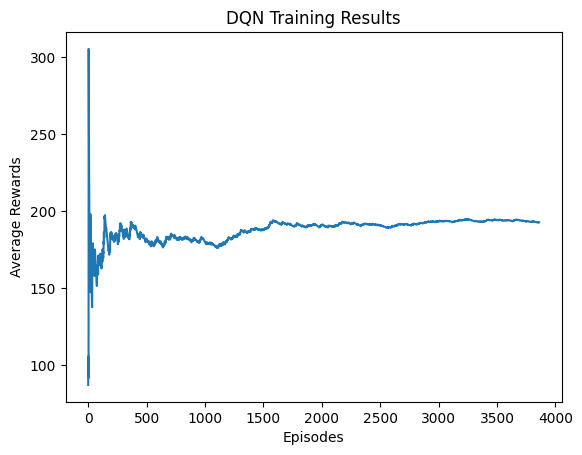

In [24]:
def plot_training_results(rewards, title='Training Results'):
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.title(title)
    plt.show()

plot_training_results(monitor.episode_rewards, title='DQN Training Results')